# Chapter 5 - Normalizing Flows

In [1]:
import numpy as np; import pandas as pd
# import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn; print(f"using torch version {torch.__version__}")
from torch import optim

#use numba's just-in-time compiler to speed things up
# from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; print('matplotlib version= ', mp.__version__)

import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
#reset matplotlib parameters to their defaults
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
font_legend = 15; font_axes=15
# LATEX
mp.rcParams.update({"text.usetex": True})
# plt.rcParams['text.usetex'] = True
# mp.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}"]  # for \text command

# %matplotlib inline
import sys; import os
from IPython.display import Image, display
# from importlib import import_module

try:
    import optuna
    print(f"using (optional) optuna version {optuna.__version__}")
except Exception:
    print('optuna is only used for hyperparameter tuning, not critical!')
    pass
import argparse
import time
# import sympy as sy

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.distributions.normal import ConditionalDiagonalNormal


using torch version 1.11.0.post2
matplotlib version=  3.5.3
using (optional) optuna version 3.0.0


In [2]:
# env = {}
# env.update(os.environ)
# env.update(source(os.environ["IQN_BASE"])) 

try:
    IQN_BASE = os.environ['IQN_BASE']
    print('BASE directoy properly set = ', IQN_BASE)
    utils_dir = os.path.join(IQN_BASE, 'utils/')
    sys.path.append(utils_dir)
    import utils
    #usually its not recommended to import everything from a module, but we know
    #whats in it so its fine
    from utils import *
    print('DATA directory also properly set, in %s' % os.environ['DATA_DIR'])
except Exception:
    # IQN_BASE=os.getcwd()
    print("""\nBASE directory not properly set. Read repo README.\
    If you need a function from utils, use the decorator below, or add utils to sys.path\n
    You can also do 
    os.environ['IQN_BASE']=<ABSOLUTE PATH FOR THE IQN REPO>
    or
    os.environ['IQN_BASE']=os.getcwd()""")
    pass

BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/torchQN
using torch version 1.11.0.post2
matplotlib version=  3.5.3
using (optional) optuna version 3.0.0
BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/torchQN
DATA directory also properly set, in /home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data
DATA directory also properly set, in /home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data


In [3]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)
#sometimes jupyter doesnt initialize MathJax automatically for latex, so do this:

In [4]:
################################### SET DATA CONFIGURATIONS ###################################
X       = ['RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam']
COND = ['genDatapT', 'genDataeta', 'genDataphi', 'genDatam']
#set order of training:
#pT_first: pT->>m->eta->phi
#m_first: m->pT->eta->phi



#we'll just go with m first since that's the order we discuss in the paper.
ORDER='m_First'

if ORDER=='m_First':
    FIELDS  = {'RecoDatam' : {'inputs': X, 
                               'xlabel':  r'$m$ (GeV)', 
                              'ylabel':'$m^{reco}$',
                               'xmin': 0, 
                               'xmax': 25},
                           

               'RecoDatapT': {'inputs': X, 
                               'xlabel':  r'$p_T$ (GeV)' , 
                              'ylabel': '$p_T^{reco}$',
                               'xmin'  : 20, 
                               'xmax'  :  100},

               'RecoDataeta': {'inputs': X, 
                               'xlabel': r'$\eta$',
                               'ylabel':'$\eta^{reco}$',
                               'xmin'  : -5,
                               'xmax'  :  5},

               'RecoDataphi'  : {'inputs': X,
                               'xlabel': r'$\phi$' ,
                                'ylabel' :'$\phi^{reco}$',
                               'xmin'  : -3.2, 
                               'xmax'  :3.2}
              }
    
PARAMS_m = {
"n_layers": int(4),
"hidden_size": int(6),
"dropout_1": float(0.6),
"dropout_2": float(0.1),
"activation": "LeakyReLU",
    'optimizer_name':'NAdam',
    'starting_learning_rate':float(0.7),
    'momentum':float(0.6),
    'batch_size':int(1024),
    'n_iterations': int(2e6),
}

all_variable_cols = [
    "genDatapT",
    "genDataeta",
    "genDataphi",
    "genDatam",
    "RecoDatapT",
    "RecoDataeta",
    "RecoDataphi",
    "RecoDatam",
]
all_cols = [
    "genDatapT",
    "genDataeta",
    "genDataphi",
    "genDatam",
    "RecoDatapT",
    "RecoDataeta",
    "RecoDataphi",
    "RecoDatam",
    "tau",
]

In [5]:
from joblib import  Memory
DATA_DIR = os.environ["DATA_DIR"]
print(f"using DATA_DIR={DATA_DIR}")
# Define a directory on device to cache python functions. One of the best ways is using joblib's Memory module
# with @Memory.cache decorator on top of a function. This saves a huge amount of time, especially in functions
# that require a long time to execute, e.g. loading data.
memory = Memory(DATA_DIR)

print("USING NEW DATASET\n")
######################################
USE_BRADEN_SCALING=False
#####################################
################################### CONFIGURATIONS ###################################
@memory.cache
def load_raw_data():
    print(f'SUBSAMPLE = {SUBSAMPLE}')
    raw_train_data=pd.read_csv(os.path.join(DATA_DIR,'train_data_10M_2.csv'),
                        usecols=all_cols,
                        nrows=SUBSAMPLE
                        )

    raw_test_data=pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'),
                        usecols=all_cols,
                        nrows=SUBSAMPLE
                        )

    raw_valid_data=pd.read_csv(os.path.join(DATA_DIR,'validation_data_10M_2.csv'),
                        usecols=all_cols,
                        nrows=SUBSAMPLE
                        )


    print('\n RAW TRAIN DATA SHAPE\n')
    print(raw_train_data.shape)
    print('\n RAW TRAIN DATA\n')
    raw_train_data.describe()#unscaled
    print('\n RAW TEST DATA\ SHAPEn')
    print(raw_test_data.shape)
    print('\n RAW TEST DATA\n')
    raw_test_data.describe()#unscaled

    return raw_train_data, raw_test_data, raw_valid_data

    
JUPYTER = False
use_subsample = True
# use_subsample = True
if use_subsample:
    SUBSAMPLE = int(
        1e5
    )  # subsample use for development - in production use whole dataset
else:
    SUBSAMPLE = None




########################################################################################
raw_train_data, raw_test_data, raw_valid_data =load_raw_data()

using DATA_DIR=/home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data
USING NEW DATASET



In [6]:
raw_train_data

,genDatapT,genDataeta,genDataphi,genDatam,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,tau
0,29.4452,0.828187,2.902130,2.85348,31.9132,0.817082,2.919510,2.59587,0.361310
1,24.3193,-1.163510,0.636469,5.83685,27.3513,-1.151020,0.652153,5.35538,0.126899
2,24.3193,-1.163510,0.636469,5.83685,27.3513,-1.151020,0.652153,5.35538,0.962307
3,24.3193,-1.163510,0.636469,5.83685,27.3513,-1.151020,0.652153,5.35538,0.457282
4,20.1703,1.844410,-0.186685,5.69090,24.2158,1.837910,-0.160621,4.59370,0.840862
...,...,...,...,...,...,...,...,...,...
99995,27.3537,-4.341310,2.264160,3.59567,30.2942,-4.349530,2.209270,3.42952,0.110503
99996,26.8630,4.460970,0.381944,6.05116,23.7580,4.521640,0.457971,4.20833,0.526119
99997,26.8630,4.460970,0.381944,6.05116,23.7580,4.521640,0.457971,4.20833,0.309711
99998,21.3142,4.150910,-2.812330,5.26289,21.9671,4.176750,-2.887050,4.14918,0.071362


In [7]:
raw_train_data.describe()

,genDatapT,genDataeta,genDataphi,genDatam,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,tau
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,32.839817,0.002209,0.007407,6.989531,32.967169,0.002216,0.007274,5.565402,0.500433
std,14.903975,2.216944,1.808915,2.789053,15.779735,2.210441,1.809601,2.685486,0.288280
min,20.000100,-5.123860,-3.141590,-0.000008,11.488700,-4.997590,-3.401475,-0.000031,0.000004
25%,23.799875,-1.664598,-1.556332,5.131500,23.487200,-1.663780,-1.556070,3.796510,0.250173
50%,28.525150,0.012869,0.014945,6.555895,29.070900,0.010939,0.017256,5.123870,0.501250
75%,36.476800,1.669738,1.568370,8.309520,37.664450,1.668075,1.564928,6.781140,0.749984
max,367.110000,5.118850,3.141550,41.075900,397.992000,4.998390,3.428875,40.567400,0.999995


In [8]:
def normal_split_t_x(df, target, input_features):
    """split dataframe into targets and feature arrays.

    Args:
        df (pandas.DataFrame): Dataframe of train, test or validation data.
        target (str): Choice of "RecoDatapT", "RecoDataeta", "RecoDataphi","RecoDatam" as target.
        input_features (list(str)): list of training features labels

    Returns:
    list(numpy.array): list of numpy array of target and training features
 """
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    # t = np.array(df[target])
    t = np.array(df[target])
    x = np.array(df[input_features])
    return t, x

In [9]:
target = "RecoDatapT"
source = FIELDS[target]
features = source["inputs"]
print("Training Features:\n", features)
print("\nTarget = ", target)

print("USING NEW DATASET\n")

Training Features:
 ['RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam']

Target =  RecoDatapT
USING NEW DATASET



In [10]:
print(f"spliting data for {target}")
train_t, train_x = normal_split_t_x(
df=raw_train_data, target=target, input_features=features
)
print("train_t shape = ", train_t.shape, "train_x shape = ", train_x.shape)
print("\n Training features:\n")
print(train_x)
valid_t, valid_x = normal_split_t_x(
df=raw_valid_data, target=target, input_features=features
)
print("valid_t shape = ", valid_t.shape, "valid_x shape = ", valid_x.shape)
test_t, test_x = normal_split_t_x(df=raw_test_data, target=target, input_features=features)
print("test_t shape = ", test_t.shape, "test_x shape = ", test_x.shape)


print("no need to train_test_split since we already have the split dataframes")
print(valid_x.mean(axis=0), valid_x.std(axis=0))
print(train_x.mean(axis=0), train_x.std(axis=0))
print(valid_t.mean(), valid_t.std())
print(train_t.mean(), train_t.std())
NFEATURES = train_x.shape[1]
######################################################

spliting data for RecoDatapT
train_t shape =  (100000,) train_x shape =  (100000, 4)

 Training features:

[[31.9132    0.817082  2.91951   2.59587 ]
 [27.3513   -1.15102   0.652153  5.35538 ]
 [27.3513   -1.15102   0.652153  5.35538 ]
 ...
 [23.758     4.52164   0.457971  4.20833 ]
 [21.9671    4.17675  -2.88705   4.14918 ]
 [44.5515    2.0938   -0.389151  6.66738 ]]
valid_t shape =  (100000,) valid_x shape =  (100000, 4)
test_t shape =  (100000,) test_x shape =  (100000, 4)
no need to train_test_split since we already have the split dataframes
[ 3.28693884e+01 -1.94726970e-03 -1.08829962e-02  5.56171091e+00] [15.57324857  2.19476169  1.81196705  2.6282735 ]
[3.29671688e+01 2.21612240e-03 7.27381886e-03 5.56540206e+00] [15.77965621  2.21042978  1.80959243  2.68547229]
32.869388404 15.573248566394462
32.967168834000006 15.77965621193832


In [11]:
print(f"spliting data for {target}")
train_t, train_x_cond = normal_split_t_x(
df=raw_train_data, target=target, input_features=COND
)
print("\n Training features:\n")
print(train_x_cond)
test_t, test_x_cond = normal_split_t_x(df=raw_test_data, target=target, input_features=COND)
print("test_t shape = ", test_t.shape, "test_x shape = ", test_x.shape)


print("no need to train_test_split since we already have the split dataframes")
print("test_x_cond shape = ", test_x_cond.shape)

print(train_x_cond.mean(axis=0), train_x_cond.std(axis=0))
print(valid_t.mean(), valid_t.std())
print(train_t.mean(), train_t.std())

spliting data for RecoDatapT

 Training features:

[[29.4452    0.828187  2.90213   2.85348 ]
 [24.3193   -1.16351   0.636469  5.83685 ]
 [24.3193   -1.16351   0.636469  5.83685 ]
 ...
 [26.863     4.46097   0.381944  6.05116 ]
 [21.3142    4.15091  -2.81233   5.26289 ]
 [34.5862    2.1022   -0.435373  4.55711 ]]
test_t shape =  (100000,) test_x shape =  (100000, 4)
no need to train_test_split since we already have the split dataframes
test_x_cond shape =  (100000, 4)
[3.28398167e+01 2.20884209e-03 7.40700042e-03 6.98953116e+00] [14.90390069  2.21693324  1.80890606  2.78903949]
32.869388404 15.573248566394462
32.967168834000006 15.77965621193832


In [12]:
def get_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from
    # the range [0, length-1] corresponding to the
    # row indices.
    rows = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)

## train

In [13]:
num_layers = 5
N_FEATURES=train_x.shape[1]
base_dist = StandardNormal(shape=[N_FEATURES])
# base_dist = ConditionalDiagonalNormal(shape=[N_FEATURES], 
                                      # context_encoder=nn.Linear(N_FEATURES, 4)
                                     # )
transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=N_FEATURES))
    transforms.append(MaskedAffineAutoregressiveTransform(features=N_FEATURES, 
                                                          hidden_features=4,
                                                         context_features=4))
    
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters(), lr = 1E-3)

In [14]:
def train_flow(n_iterations):
    for i in range(n_iterations):
        # get data (reco jets)
        batch_x, batch_t = get_batch(train_x, train_t, 58)
        x = torch.tensor(batch_x, dtype=torch.float32)
        # get conditioning variables (gen jets)
        batch_x_cond, batch_t = get_batch(train_x_cond, train_t, 58)
        x_cond = torch.tensor(batch_x_cond, dtype=torch.float32)
        
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs = x, context = x_cond).mean()
        loss.backward()
        optimizer.step()

In [15]:
train_flow(5000)

In [16]:
test_x.shape

(100000, 4)

In [17]:
def evaluate_flow():
    test_X=torch.tensor(test_x, dtype=torch.float32)
    likelihood  = flow.log_prob(test_X).exp()
    return likelihood

In [18]:
likelihood = evaluate_flow()

In [19]:
likelihood.shape

torch.Size([100000])

In [36]:
SUBSAMPLE=1000
rows = np.random.choice(len(test_x_cond), SUBSAMPLE)

In [37]:
test_x_cond_context = test_x_cond[rows]
test_x_cond_context

array([[28.84    , -1.2665  ,  2.29766 , 12.1307  ],
       [24.1136  , -4.27195 ,  1.43597 ,  7.71134 ],
       [23.3072  ,  4.6496  , -0.951818,  5.17797 ],
       ...,
       [20.1731  , -0.552215,  1.33108 ,  5.76411 ],
       [52.433   ,  0.806837,  0.189618, 10.6374  ],
       [37.1635  ,  2.75244 ,  1.79586 ,  7.63404 ]])

(array([732., 187.,  53.,  16.,   4.,   2.,   2.,   2.,   0.,   2.]),
 array([ 20.0305 ,  35.83615,  51.6418 ,  67.44745,  83.2531 ,  99.05875,
        114.8644 , 130.67005, 146.4757 , 162.28135, 178.087  ]),
 <BarContainer object of 10 artists>)

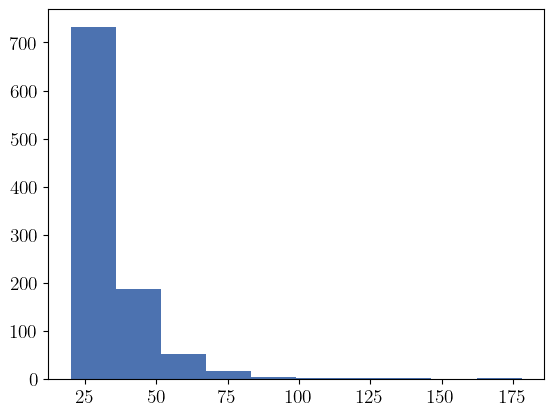

In [38]:
plt.hist(test_x_cond_context[:,0])

In [39]:
context = torch.tensor(test_x_cond_context,dtype=torch.float32)
context

tensor([[28.8400, -1.2665,  2.2977, 12.1307],
        [24.1136, -4.2719,  1.4360,  7.7113],
        [23.3072,  4.6496, -0.9518,  5.1780],
        ...,
        [20.1731, -0.5522,  1.3311,  5.7641],
        [52.4330,  0.8068,  0.1896, 10.6374],
        [37.1635,  2.7524,  1.7959,  7.6340]])

In [ ]:
samples = flow.sample(
    # test_x.shape[0],
    2000,
    context = context
    
).detach().numpy()
samples

In [30]:
samples.shape

(1, 200000, 4)

In [31]:
samples[:, :, 0]

array([[41.57598 , 54.761528, 29.230541, ..., 73.444275, 15.749493,
        40.730896]], dtype=float32)

In [34]:
ind = 0
samples[ind, :, ind].min(), samples[ind, :, ind].max(), samples[ind, :, ind].mean()

(-34.551365, 1954.3479, 38.714733)

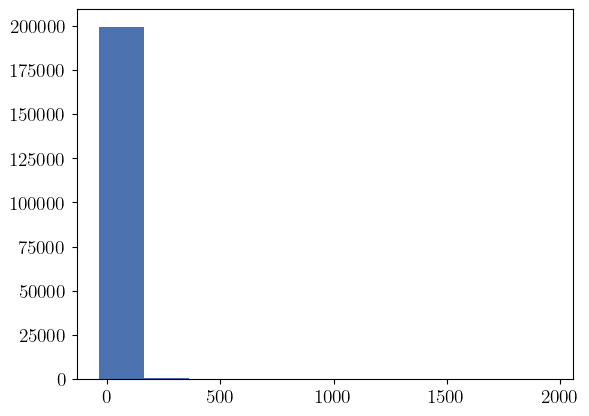

In [35]:
plt.hist(samples[0, :, 0].flatten());

## Shape of samples


`samples` Shape: (1000, 100, 4)

- Dimension 0 (size 1000): Corresponds to each conditioning variable in context. So, for each of the 1000 conditioning variables, you have generated samples.

- Dimension 1 (size 100): Represents the number of samples generated per conditioning variable.

- Dimension 2 (size 4): Represents the features (dimensions) of each generated sample.

Therefore, `samples[i, j, k]` gives you:

- i (0 ≤ i < 1000): The index of the conditioning variable (context index).
- j (0 ≤ j < 100): The index of the sample generated for that conditioning variable.
- k (0 ≤ k < 4): The index of the feature in the generated sample.

# Plot

In [49]:

def get_hist_simple(predicted_dist, target):
    
    range_ = (FIELDS[target]["xmin"], FIELDS[target]["xmax"])
    bins=50
    predicted_label_counts, label_edges = np.histogram(
        predicted_dist, range=range_, bins=bins
    )
    
    REAL_DIST = raw_test_data[target]
    real_label_counts, _ = np.histogram(REAL_DIST, range=range_, bins=bins)
    label_edges = label_edges[1:] / 2 + label_edges[:-1] / 2
    return real_label_counts, predicted_label_counts, label_edges

In [50]:
def plot_one(
    target, real_edges, real_counts, predicted_counts, save_plot=False, PARAMS=None, JUPYTER=True
):
    norm_data = raw_test_data.shape[0]
    norm_predicted = samples.shape[0]
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(3.5 * 3 / 2.5, 3.8), gridspec_kw={"height_ratios": [2, 0.5]}
    )
    ax1.step(
        real_edges, real_counts / norm_data, where="mid", color="k", linewidth=0.5
    )  # step real_count_pt
    
    ax1.step(
        real_edges,
        predicted_counts / norm_predicted,
        where="mid",
        color="#D7301F",
        linewidth=0.5,
    )  # step predicted_count_pt
    ax1.scatter(
        real_edges,
        real_counts / norm_data,
        label="reco",
        color="k",
        facecolors="none",
        marker="o",
        s=5,
        linewidth=0.5,
    )
    ax1.scatter(
        real_edges,
        predicted_counts / norm_predicted,
        label="NF",
        color="#D7301F",
        marker="x",
        s=5,
        linewidth=0.5,
    )
    ax1.set_xlim(range_)
    ax1.set_ylim(0, max(predicted_counts / norm_predicted) * 1.1)
    ax1.set_ylabel("counts")
    ax1.set_xticklabels([])
    ax1.legend(loc="upper right")

    ratio = (predicted_counts / norm_predicted) / (real_counts / norm_data)
    ax2.scatter(
        real_edges, ratio, color="r", marker="x", s=5, linewidth=0.5
    )  # PREDICTED (IQN)/Reco (Data)
    ax2.scatter(
        real_edges,
        ratio / ratio,
        color="k",
        marker="o",
        facecolors="none",
        s=5,
        linewidth=0.5,
    )
    ax2.set_xlim(range_)
    ax2.set_xlabel(FIELDS[target]["xlabel"])
    ax2.set_ylabel(
        r"$\frac{\textnormal{predicted}}{\textnormal{reco}}$"
        #    , fontsize=10
    )
    ax2.set_ylim((YLIM))
    ax2.set_xlim(range_)
    ax2.set_yticklabels([0.8, 1.0, 1.2])
#     if JUPYTER==True:
#         plt.show()
#     else:
        
#         plt.tight_layout()
#         fig.subplots_adjust(wspace=0.5, hspace=0.2)
#         fig.subplots_adjust(wspace=0.0, hspace=0.1)
#         plt.axis('off')


    if save_plot:
        # plot_filename = utils.get_model_filename(target, PARAMS).split(".dict")[0] + ".png"
        plot_filename = 'NF_' + target + '.pdf'
        plt.savefig(
            os.path.join(IQN_BASE, "JupyterBook", 
                         "images", "NF", plot_filename),
            bbox_inches='tight'
        )


    fig.show()
    plt.show();
    # plt.gca().set_position([0, 0, 1, 1])



## $p_T$

In [51]:
target = 'RecoDatapT'
range_ = (FIELDS[target]["xmin"], FIELDS[target]["xmax"])
bins = 50

YLIM = (0.8, 1.2)

real_label_counts_pT, predicted_label_counts_pT, label_edges_pT = get_hist_simple(
    predicted_dist=samples[:,0], target=target
)

/tmp/ipykernel_2112041/2957069285.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0.8, 1.0, 1.2])
/tmp/ipykernel_2112041/2957069285.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


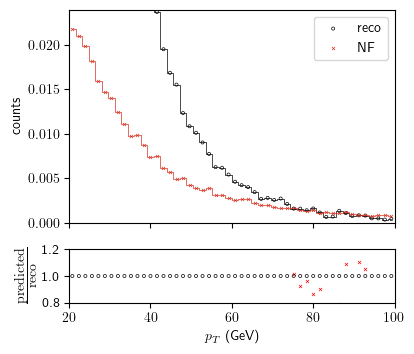

In [52]:
plot_one(
    target=target,
    real_edges=label_edges_pT,
    real_counts=real_label_counts_pT,
    predicted_counts=predicted_label_counts_pT,
    save_plot=True,
    PARAMS=PARAMS_m
)

## $\eta$

In [182]:
target = 'RecoDataeta'
range_ = (FIELDS[target]["xmin"], FIELDS[target]["xmax"])
bins = 50

YLIM = (0.8, 1.2)

real_label_counts_eta, predicted_label_counts_eta, label_edges_eta = get_hist_simple(
    predicted_dist=samples[:,1], target=target
)

/tmp/ipykernel_2060471/2957069285.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0.8, 1.0, 1.2])
/tmp/ipykernel_2060471/2957069285.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


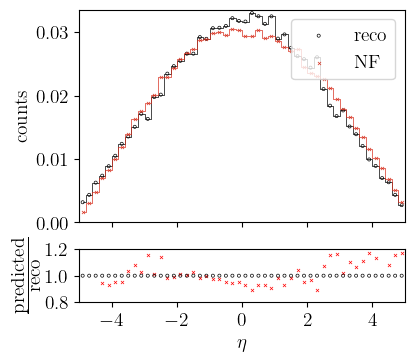

In [183]:
plot_one(
    target=target,
    real_edges=label_edges_eta,
    real_counts=real_label_counts_eta,
    predicted_counts=predicted_label_counts_eta,
    save_plot=True,
    PARAMS=PARAMS_m
)

## $\phi$

In [184]:
target = 'RecoDataphi'
range_ = (FIELDS[target]["xmin"], FIELDS[target]["xmax"])
bins = 50

YLIM = (0.8, 1.2)

real_label_counts_phi, predicted_label_counts_phi, label_edges_phi = get_hist_simple(
    predicted_dist=samples[:,2], target=target
)

/tmp/ipykernel_2060471/2957069285.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0.8, 1.0, 1.2])
/tmp/ipykernel_2060471/2957069285.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


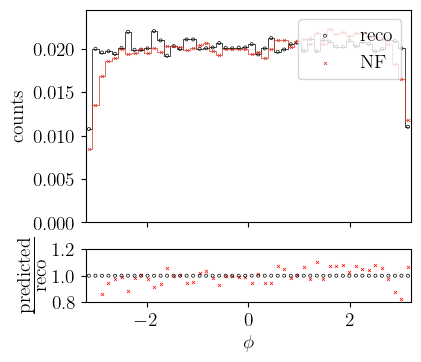

In [185]:
plot_one(
    target=target,
    real_edges=label_edges_phi,
    real_counts=real_label_counts_phi,
    predicted_counts=predicted_label_counts_phi,
    save_plot=True,
    PARAMS=PARAMS_m
)

## $m$

In [186]:
target = 'RecoDatam'
range_ = (FIELDS[target]["xmin"], FIELDS[target]["xmax"])
bins = 50

YLIM = (0.8, 1.2)

real_label_counts_m, predicted_label_counts_m, label_edges_m = get_hist_simple(
    predicted_dist=samples[:,3], target=target
)

/tmp/ipykernel_2060471/2957069285.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0.8, 1.0, 1.2])
/tmp/ipykernel_2060471/2957069285.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


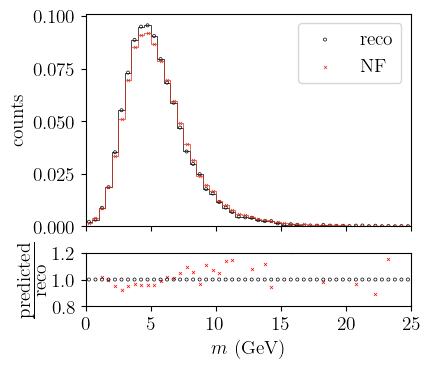

In [187]:
plot_one(
    target=target,
    real_edges=label_edges_m,
    real_counts=real_label_counts_m,
    predicted_counts=predicted_label_counts_m,
    save_plot=True,
    PARAMS=PARAMS_m
)